In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

import xgboost as xgb
from xgboost import plot_importance

In [2]:
dataset = pd.read_pickle("data/dataset.pkl")

In [5]:
dataset.head()

,uid,pitch_type,type_confidence,inning,top,score_diff,at_bat_num,p_throws,pcount_pitcher,bases_state,...,height_inches,prev_pitch_type,prev_type,prev_end_speed,prev_break_length,prev_break_angle,prev_break_y,prev_zone,prev_spin_dir,prev_spin_rate
0,14143252,FF,2.0,1,False,0,7,R,1,000,...,70,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143253,FF,2.0,1,False,0,7,R,2,000,...,70,FF,R,81.4,2.8,-0.7,23.9,8.0,183.148,2519.455
2,14143254,FF,2.0,1,False,0,7,R,3,000,...,70,FF,R,84.0,1.9,6.9,23.8,12.0,187.663,2838.803
3,14143255,FF,2.0,1,False,0,7,R,4,000,...,70,FF,R,83.8,2.3,-12.4,23.9,14.0,179.643,2701.919
4,14143256,FF,2.0,1,False,0,7,R,5,000,...,70,FF,R,84.0,2.1,0.1,23.8,3.0,184.623,2683.280


In [13]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

569472.8
71184.1


In [17]:
train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [28]:
train_y.cat.codes

0         4
1         4
2         4
3         4
4         4
         ..
569479    7
569480    4
569481    0
569482    4
569483    0
Length: 569484, dtype: int8

In [25]:
train_X = training_set.drop(["uid", "pitch_type", "type_confidence"],axis=1)
train_y = training_set['pitch_type']

val_X = validation_set.drop(["uid", "pitch_type", "type_confidence"],axis=1)
val_y = validation_set['pitch_type']

In [31]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, 
                                        objective='objective=multi:softmax', eval_metric='merror')
val_stats = clf.fit(train_X, train_y.cat.codes, eval_set=[(val_X, val_y.cat.codes)])

[0]	validation_0-merror:0.59287
[1]	validation_0-merror:0.59211
[2]	validation_0-merror:0.59155
[3]	validation_0-merror:0.59130
[4]	validation_0-merror:0.59150
[5]	validation_0-merror:0.59133
[6]	validation_0-merror:0.59120
[7]	validation_0-merror:0.59100
[8]	validation_0-merror:0.59060
[9]	validation_0-merror:0.59055
[10]	validation_0-merror:0.59016
[11]	validation_0-merror:0.59009
[12]	validation_0-merror:0.58998
[13]	validation_0-merror:0.58991
[14]	validation_0-merror:0.58977
[15]	validation_0-merror:0.58944
[16]	validation_0-merror:0.58914
[17]	validation_0-merror:0.58916
[18]	validation_0-merror:0.58916
[19]	validation_0-merror:0.58926
[20]	validation_0-merror:0.58935
[21]	validation_0-merror:0.58908
[22]	validation_0-merror:0.58916
[23]	validation_0-merror:0.58929
[24]	validation_0-merror:0.58904
[25]	validation_0-merror:0.58916
[26]	validation_0-merror:0.58930
[27]	validation_0-merror:0.58936
[28]	validation_0-merror:0.58902
[29]	validation_0-merror:0.58895
[30]	validation_0-me

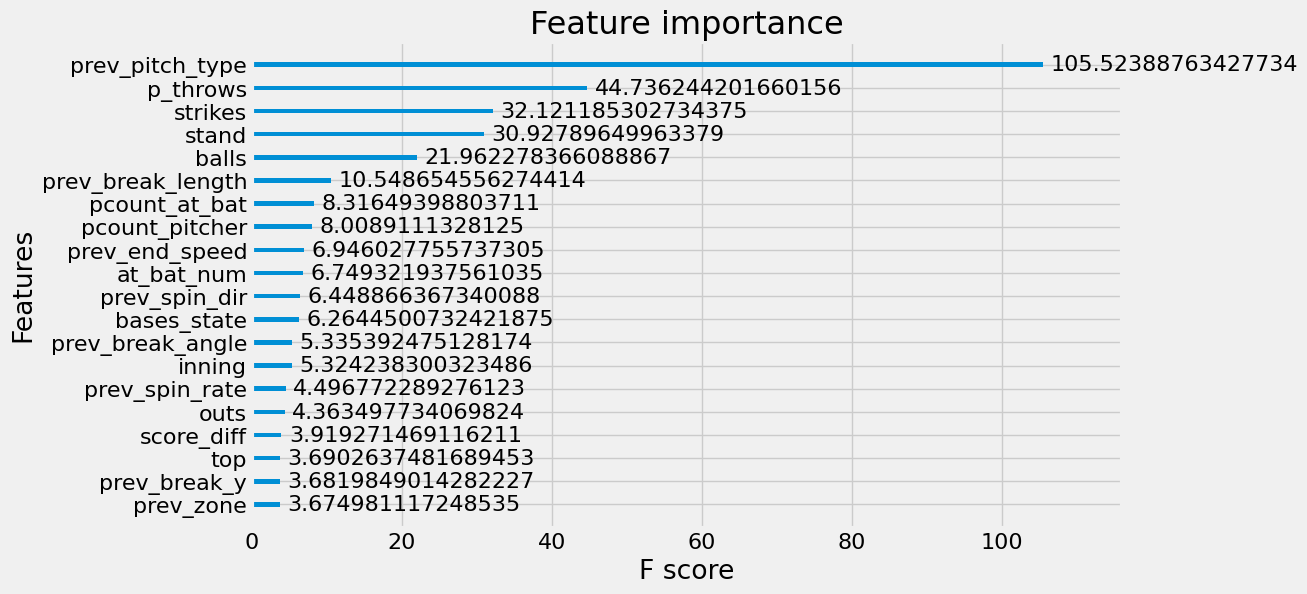

In [38]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.show()

In [ ]:
# return score and params
def grid_search(model, X, y, param_grid, num_folds, eval_scoring_str):
    clf = GridSearchCV(
        model,
        param_grid,
        verbose=1,
        cv=num_folds, 
        refit=True,
        scoring=eval_scoring_str  #accuracy, neg_log_loss, roc_auc
    )
    clf.fit(X, y)
    print(f"{clf.best_score_}")
    print(f"{clf.best_params_}")
    return clf

def run_grid_search():
    param_grid = {"max_depth":    [6, 4],
              "learning_rate": [0.1],
              "n_estimators": [100, 500, 600]
            }
    NUM_FOLDS=5
    grid_search_xg = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, 
                                        objective='reg:squarederror')
    grid_search_cv = grid_search(grid_search_xg, X, dataset['Score'], 
                                param_grid, num_folds=NUM_FOLDS, eval_scoring_str='neg_mean_squared_error')    # neg_mean_squared_error
    grid_search_model = grid_search_cv.best_estimator_
    grid_search_preds = cross_val_predict(grid_search_model, X, dataset['Score'], cv=X.shape[0])
